In [108]:
## spatial weights with pysal
import pysal as ps
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.api as st
import patsy
import numpy as np
import glob
import os
drop=os.getenv('DROPBOX_LOC')

from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas as gpd
from pyproj import Proj

import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
#sns.set(style="darkgrid")
plt.style.use('fivethirtyeight')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I grabbed a bunch of viewports' worth of redfin listings and saved them. We load all of them, and kick out dupes.

In [109]:
files=glob.glob(os.path.join(drop,'Documents/Data/Housing/redfin','redfin_2017-06*'))

In [110]:
## Load and drop dupes
keeps=[]
for f in files:
    temp=pd.read_csv(f,parse_dates=['SOLD DATE'])
    keeps.append(temp)
redfin=pd.concat(keeps)
redfin=redfin.drop_duplicates('MLS#')

### Basic processing 

In [111]:
redfin=redfin.rename(columns=lambda x: x.replace(' ','_'))
redfin['year']=redfin.SOLD_DATE.map(lambda x: x.year)
redfin['month']=redfin.SOLD_DATE.map(lambda x: x.month)
redfin['quarter']=redfin.SOLD_DATE.map(lambda x: x.quarter)
redfin['bldg_age_at_sale']=redfin.year-redfin.YEAR_BUILT
redfin['sqft_100']=redfin.SQUARE_FEET/100
redfin['sqft_100_2']=redfin['sqft_100']*redfin['sqft_100']
redfin.LOCATION=redfin.LOCATION.replace({'Montclaire':'Montclair','Montclair Distri':'Montclair',
                                         'Crocker Hghlands':'Crocker Highlands','Glenview (Uppr)':'Upper Glenview',
                                        'Grand Lake/ Rose':'Grand Lake'}).str.title()

redfin[redfin.LONGITUDE.notnull()]
redfin.LOCATION=redfin.LOCATION.str.replace('Dist.','District').str.replace(' |\-','_').str.replace('\.|/|\-','')

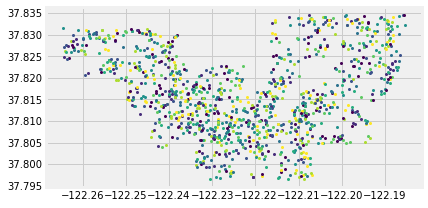

In [112]:
## Turn to geodataframe

redfin['geometry'] = redfin.apply(lambda x: Point(x.LONGITUDE,x.LATITUDE),axis=1)
redfin = gpd.GeoDataFrame(redfin).set_geometry(col='geometry',crs=from_epsg(4326))
redfin.plot()

In [113]:
## define variable groups

coords = ['LONGITUDE','LATITUDE']
xvars=['sqft_100','bldg_age_at_sale','BATHS','BEDS','LOCATION']
yvar=['PRICE']

In [114]:
subset = redfin.ix[redfin.year.isin(tempyr),yvar+xvars+coords].dropna().\
drop_duplicates(coords)

In [115]:
w = ps.weights.KNN(subset.loc[:,coords\
                              ].values, k=3)
w.transform = 'R'
print sf_2013.shape
w.s2array.shape

(4525, 80)


(1133L, 1L)

In [116]:
subset=subset.merge(pd.get_dummies(subset[vartypes]),left_index=True,right_index=True)
subset

,PRICE,sqft_100,bldg_age_at_sale,BATHS,BEDS,LOCATION,LONGITUDE,LATITUDE,LOCATION_699___Not_Defined,LOCATION_Alameda,...,LOCATION_Upper_Diamond,LOCATION_Upper_Glenview,LOCATION_Upper_Lakeshore,LOCATION_Upper_Montclair,LOCATION_Upper_Oakmore,LOCATION_Upper_Piedmont,LOCATION_Wildwood,LOCATION_Wildwood_Gardens,LOCATION_Wilshire_Heights,LOCATION_Woodminster
0,2100000,67.83,25.0,4.0,5.0,Piedmont,-122.215851,37.822084,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2100000,67.83,25.0,4.0,5.0,Piedmont,-122.215851,37.822084,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1050000,999.99,54.0,4.0,8.0,Lincoln_Highland,-122.207859,37.805504,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1050000,999.99,54.0,4.0,8.0,Lincoln_Highland,-122.207859,37.805504,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3500000,63.60,44.0,4.5,5.0,Piedmont,-122.213517,37.819352,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3600000,56.41,78.0,5.5,4.0,Oakmore,-122.209086,37.815662,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1355000,51.80,64.0,5.0,4.0,Joaquin_Miller,-122.194315,37.809324,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2725000,53.57,68.0,5.5,5.0,Piedmont,-122.216005,37.813570,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3700998,52.14,85.0,4.5,5.0,Piedmont,-122.213684,37.817055,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3700998,52.14,85.0,4.5,5.0,Piedmont,-122.213684,37.817055,0,0,...,0,0,0,0,0,0,0,0,0,0


## Compare regressions run with categorical contrasts vs dummies

I want to see how different the coefficients and model fit might be.

In [117]:
## get dummies for string vars--a bit silly since it is really just the LOCATION variable.

vartypes=subset[xvars].dtypes=='object'
vartypes=vartypes[vartypes==True].index
vartypes

Index([u'LOCATION'], dtype='object')

In [118]:
## Get a list of all enumerated dummy var names, with LOCATION prepended
fulldummylist =[] 
for v in vartypes:
    for c in subset.columns:
        #print c
        if v in c and v!=c:
            
            fulldummylist.append(c)

## remove glenview so dummies are not perfectly collinear
fulldummylist.remove('LOCATION_Glenview')

In [119]:
## Version treating neighborhoods as contrasts relative to Glenview as base category

m0 = sm.ols("np.log(PRICE) ~%s+ C(LOCATION, Treatment(reference='Glenview'))"%'+'.join(xvars[:-1]), 
                  data=subset).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(PRICE)   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     115.0
Date:                Wed, 14 Jun 2017   Prob (F-statistic):               0.00
Time:                        20:23:56   Log-Likelihood:                 134.96
No. Observations:                4525   AIC:                            -117.9
Df Residuals:                    4449   BIC:                             369.8
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              13.3148      0.027    484.468      0.000      13.261      13.369
C(LOCATION, Treatment(reference='Glenview'))[T.699___Not_Defined]      -0.3935      0.107     -3.686      0.000      -0.603      -0.184
C(LOCATION, Treatment(reference='Glenview'))[T.Alameda]                 0.4820      0.073      6.647      0.000       0.340       0.624
C(LOCATION, Treatment(reference='Glenview'))[T.Alameda_County]         -0.3986      0.120     -3.309      0.001      -0.635      -0.162
C(LOCATION, Treatment(reference='Glenview'))[T.Baja_Glenview]          -0.6456      0.098     -6.617      0.000      -0.837      -0.454
C(LOCATION, Treatment(reference='Glenview'))[T.Bella_Vista_Hill]       -0.3406      0.053     -6.394      0.000      -0.445      -0.236
C(LOCATION, Treatment(reference='Glenview'))[T.Central_Piedmont]        0.7597      0.040     19.220      0.000       0.682       0.837
C(LOCATION, Treatment(reference='Glenview'))[T.China_Hill]             -0.1361      0.076     -1.786      0.074      -0.285       0.013
C(LOCATION, Treatment(reference='Glenview'))[T.Cleveland_Heights]      -0.1950      0.137     -1.419      0.156      -0.464       0.074
C(LOCATION, Treatment(reference='Glenview'))[T.Crocker]                 0.1541      0.056      2.762      0.006       0.045       0.264
C(LOCATION, Treatment(reference='Glenview'))[T.Crocker_Highlands]       0.2449      0.016     15.321      0.000       0.214       0.276
C(LOCATION, Treatment(reference='Glenview'))[T.Diamond_Districtict]    -0.3135      0.039     -8.099      0.000      -0.389      -0.238
C(LOCATION, Treatment(reference='Glenview'))[T.Diamond_Heights]        -0.1752      0.054     -3.218      0.001      -0.282      -0.068
C(LOCATION, Treatment(reference='Glenview'))[T.Downtown]               -0.1269      0.168     -0.754      0.451      -0.457       0.203
C(LOCATION, Treatment(reference='Glenview'))[T.East_Oakland]           -0.7967      0.168     -4.742      0.000      -1.126      -0.467
C(LOCATION, Treatment(reference='Glenview'))[T.Fruitvale]              -0.1544      0.137     -1.124      0.261      -0.424       0.115
C(LOCATION, Treatment(reference='Glenview'))[T.Fruitvale_Laurel]       -0.3984      0.168     -2.371      0.018      -0.728      -0.069
C(LOCATION, Treatment(reference='Glenview'))[T.Glenview_District]       0.0141      0.052      0.271      0.786      -0.088       0.116
C(LOCATION, Treatment(reference='Glenview'))[T.Grand_Lake]              0.0282      0.025      1.129      0.259      -0.021       0.077
C(LOCATION, Treatment(reference='Glenview'))[T.Haddon_Hill]            -0.1579      0.067  

In [121]:
## dummy version instead--notice the R squared in the .29 territory as opposed to .66 for the contrast version

m1 = sm.ols("np.log(PRICE) ~%s"%'+'.join(xvars[:-1]+fulldummylist), 
                  data=subset).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(PRICE)   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     24.61
Date:                Wed, 14 Jun 2017   Prob (F-statistic):          1.81e-275
Time:                        20:24:24   Log-Likelihood:                -1518.4
No. Observations:                4525   AIC:                             3189.
Df Residuals:                    4449   BIC:                             3677.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       13.3801      0.034    394.542      0.000      13.314      13.447
sqft_100                         0.0019      0.000      7.727      0.000       0.001       0.002
bldg_age_at_sale                 0.0023      0.000     10.806      0.000       0.002       0.003
BATHS                            0.2217      0.007     30.557      0.000       0.207       0.236
BEDS                            -0.0547      0.007     -7.341      0.000      -0.069      -0.040
LOCATION_699___Not_Defined      -0.4026      0.154     -2.619      0.009      -0.704      -0.101
LOCATION_Alameda                -0.0295      0.104     -0.282      0.778      -0.234       0.175
LOCATION_Alameda_County         -0.0825      0.172     -0.481      0.631      -0.419       0.254
LOCATION_Baja_Glenview          -0.2245      0.141     -1.598      0.110      -0.500       0.051
LOCATION_Bella_Vista_Hill       -0.0594      0.077     -0.775      0.438      -0.210       0.091
LOCATION_Central_Piedmont        0.2286      0.057      4.040      0.000       0.118       0.339
LOCATION_China_Hill              0.0951      0.109      0.868      0.385      -0.120       0.310
LOCATION_Cleveland_Heights      -0.1442      0.198     -0.728      0.466      -0.532       0.244
LOCATION_Crocker                 0.0146      0.080      0.182      0.855      -0.143       0.172
LOCATION_Crocker_Highlands       0.0066      0.023      0.291      0.771      -0.038       0.051
LOCATION_Diamond_Districtict    -0.1360      0.056     -2.441      0.015      -0.245      -0.027
LOCATION_Diamond_Heights        -0.0314      0.078     -0.400      0.689      -0.185       0.122
LOCATION_Downtown                0.1377      0.242      0.568      0.570      -0.337       0.613
LOCATION_East_Oakland           -0.5592      0.242     -2.310      0.021      -1.034      -0.085
LOCATION_Fruitvale              -0.0715      0.198     -0.361      0.718      -0.460       0.317
LOCATION_Fruitvale_Laurel       -0.3321      0.242     -1.372      0.170      -0.807       0.142
LOCATION_Glenview_District      -0.1246      0.075     -1.661      0.097      -0.272       0.022
LOCATION_Grand_Lake             -0.0350      0.035     -0.989      0.323      -0.104       0.034
LOCATION_Haddon_Hill             0.1161      0.097      1.202      0.229      -0.073       0.306
LOCATION_Highland_Heights       -0.1855      0.069     -2.674      0.008      -0.322      -0.049
LOCATION_Joaquin_Miller         -0.1359      0.062     -2.187      0.029      -0.258      -0.014
LOCATION_Lake_Merritt            0.0913      0.141      0.650      0.516      -0.184       0.367
LOCATION_Lakeshore              -0.0195      0.055     -0.354      0.723      -0.127       0.088
LOCATION_LakeshoreGrand          0.0391      0.055      0.717      0.473    

### Compare parameters for the two approaches

In [122]:
m0_params=m0.params.reset_index(name='categorical')
## extract neighborhood
ptrn = r'T\.(.*?)\]'
m0_params['param']=m0_params['index'].str.extract(ptrn)
m0_params.loc[m0_params.param.isnull(),'param']=m0_params.loc[m0_params.param.isnull(),'index']
m0_params=m0_params.drop('index',axis=1).set_index('param')


C:\Users\akselo\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [123]:
m1_params=m1.params.reset_index(name='dummies')
m1_params['param']=m1_params['index'].str.replace('LOCATION_','')
m1_params=m1_params.drop('index',axis=1).set_index('param')

In [126]:
combo = pd.concat([m1_params,m0_params],axis=1)
combo

,dummies,categorical
699___Not_Defined,-0.402577,-0.393517
Alameda,-0.029501,0.482038
Alameda_County,-0.082533,-0.398617
BATHS,0.221652,0.142154
BEDS,-0.054706,0.003038
Baja_Glenview,-0.224506,-0.645559
Bella_Vista_Hill,-0.059442,-0.340607
Central_Piedmont,0.228576,0.759697
China_Hill,0.095083,-0.136091
Cleveland_Heights,-0.144193,-0.195045


The differences are substantial and requires more investigation both for overall model fit and coefficients.

## Lagged models

In [15]:


m2 = ps.spreg.OLS(np.log(sf_2013.PRICE).values[:, None], 
                  sf_2013[xvars[:-1]].values, \
                  w=w, spat_diag=True, \
                  name_x=xvars[:-1], name_y='ln(price)') 

print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        1133
Mean dependent var  :     13.9852                Number of Variables   :           4
S.D. dependent var  :      0.4076                Degrees of Freedom    :        1129
R-squared           :      0.2817
Adjusted R-squared  :      0.2798
Sum squared residual:     135.060                F-statistic           :    147.5761
Sigma-square        :       0.120                Prob(F-statistic)     :   1.109e-80
S.E. of regression  :       0.346                Log likelihood        :    -402.765
Sigma-square ML     :       0.119                Akaike info criterion :     813.530
S.E of regression ML:      0.3453                Schwarz criterion     :     833.660

-----------------------------------------------------------------------------